# Predicción de la tasa de churn

## Descripción del dataset

Nuestro dataset contiene información de clientes con las siguientes columnas:

- **CustomerID**: identificador único de cada cliente.  
- **Age**: edad del cliente. Puede influir en la propensión a abandonar según segmento.  
- **Gender**: género del cliente, útil para segmentación y patrones de comportamiento.  
- **Tenure**: tiempo que el cliente lleva usando el servicio; clientes nuevos suelen tener más riesgo de churn.  
- **Usage Frequency**: frecuencia de uso del servicio; un uso bajo puede indicar riesgo de abandono.  
- **Support Calls**: número de llamadas al soporte; clientes con problemas recurrentes pueden tener mayor riesgo.  
- **Payment Delay**: retrasos en pagos; indicador financiero de riesgo de churn.  
- **Subscription Type**: tipo de suscripción contratada; ciertos planes pueden tener mayor tasa de abandono.  
- **Contract Length**: duración del contrato; contratos cortos suelen tener mayor rotación.  
- **Total Spend**: gasto total del cliente; clientes de mayor gasto pueden ser más leales.  
- **Last Interaction**: tiempo desde la última interacción con el servicio; inactividad prolongada puede indicar riesgo de churn.  
- **Churn**: variable objetivo (1 si el cliente abandonó, 0 si permanece).

Estas columnas nos permiten generar **features relevantes** para predecir la probabilidad de churn.

## Enfoque de modelado

Dado que tenemos datos históricos etiquetados, aplicaremos **aprendizaje supervisado**.  

Inicialmente probaremos **varios modelos supervisados** para comparar su desempeño y seleccionar el más adecuado. Entre ellos:

- **Logistic Regression**  
- **Decision Tree**  
- **Random Forest**  
- **K-Nearest Neighbors (KNN)**  
- **Support Vector Machine (SVM)**  
- **Gradient Boosting / LightGBM**  

Este enfoque nos permitirá obtener **predicciones de churn confiables** y estimar la probabilidad de abandono de cada cliente.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from math import sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
warnings.filterwarnings('ignore')


## 1. Importación de paquetes y dataset

In [7]:
df_test = pd.read_csv('../data/raw/customer_churn_dataset-testing-master.csv')
df_train = pd.read_csv('../data/raw/customer_churn_dataset-training-master.csv')

## 2.EDA y Visual EDA

In [8]:
df_train.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [9]:
df_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  str    
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  str    
 8   Contract Length    440832 non-null  str    
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), str(3)
memory usage: 40.4 MB


In [10]:
df_train.columns

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='str')

In [14]:
df_train.isnull().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [12]:
df_train.duplicated().sum()

np.int64(0)

### 2.1 Conocer las variables categóricas

In [ ]:
print('Generos:\n', df_train['Gender'].unique())

Generos:
 <StringArray>
['Female', 'Male']
Length: 2, dtype: str


In [18]:
print('Subscripciones:\n', df_train['Subscription Type'].unique())

Subscripciones:
 <StringArray>
['Standard', 'Basic', 'Premium']
Length: 3, dtype: str


In [20]:
print('Longitud del contrato:\n', df_train['Contract Length'].unique())

Longitud del contrato:
 <StringArray>
['Annual', 'Monthly', 'Quarterly']
Length: 3, dtype: str


### 2.2 Conocer las variables numericas

#### 2.2.1 CustomerID

In [ ]:
# El campo CustomerID no aporta información relevante para el análisis, por lo que no se analizara más a fondo.

#### 2.2.2 Age

In [22]:
print('Min edad: ', df_train['Age'].max())
print('Max edad: ', df_train['Age'].min())
print('Valores Nulos: ', df_train['Age'].isnull().any())

Min edad:  65.0
Max edad:  18.0
Valores Nulos:  False


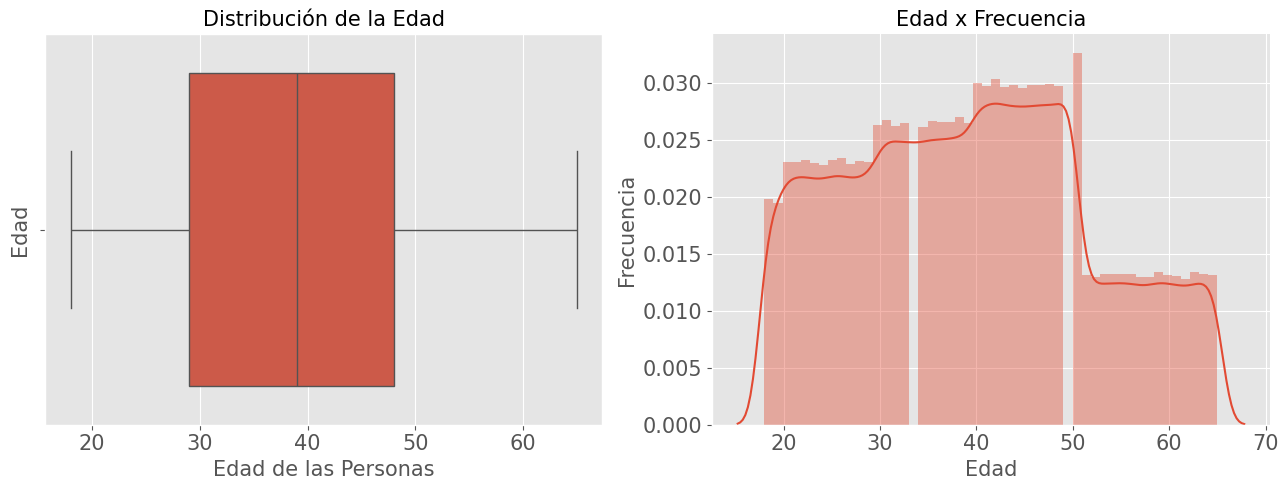

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))

# Gráfico 1: Diagrama de Caja (Boxplot)
sns.boxplot(x = 'Age', data = df_train, orient = 'v', ax = ax1)
ax1.set_xlabel('Edad de las Personas', fontsize=15)
ax1.set_ylabel('Edad', fontsize=15)
ax1.set_title('Distribución de la Edad', fontsize=15)
ax1.tick_params(labelsize=15)

# Gráfico 2: Histograma de distribución
sns.distplot(df_train['Age'], ax = ax2)
sns.despine(ax = ax2)
ax2.set_xlabel('Edad', fontsize=15)
ax2.set_ylabel('Frecuencia', fontsize=15)
ax2.set_title('Edad x Frecuencia', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()



#### 2.2.3 Tenure

#### 2.2.4 Usage

#### 2.2.5 Frequency

#### 2.2.6 Support Calls

#### 2.2.7 Payment Delay

#### 2.2.8 Total Spend

#### 2.2.9 Last Interaction

#### 2.2.10 Total Churn

## 3. Preprocessing data

In [15]:
#Debido a los pocos valores nulos que hay en el dataset, se opta por eliminar las filas que los contienen.
df_train.dropna(inplace=True)

In [ ]:
# Borrar CustomerID
df_train.drop(columns=['CustomerID'], inplace=True)